# ADA project: Milestone 2
### Team: YiYiSoDa - Yinghui Jiang, Yichen Wang, Sophia Ly, David Chaves

In [20]:
import seaborn as sns
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import numpy as np
import tarfile
import re
import gzip
import spacy

data_folder = './data/MovieSummaries/'
corenlp_folder = './data/corenlp_plot_summaries/'

## Task 1: Explore the dataset

#### 1.1 Load the data

#### movie.metadata.tsv.gz


Metadata for 81,741 movies, extracted from the Noverber 4, 2012 dump of Freebase.  Tab-separated; columns:

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie name
4. Movie release date
5. Movie box office revenue
6. Movie runtime
7. Movie languages (Freebase ID:name tuples)
8. Movie countries (Freebase ID:name tuples)
9. Movie genres (Freebase ID:name tuples)


In [21]:
movies = data_folder + 'movie.metadata.tsv'
movies_cols = ['wiki_movie_id', 'freebase_movie_id', 'movie_name','release_date','box_office_revenue',
              'movie_runtime', 'languages', 'countries','genres']

movies = pd.read_csv(movies, sep='\t', names=movies_cols, parse_dates=["release_date"], date_parser=lambda x: pd.to_datetime(x, errors="coerce"))
movies.head()

,wiki_movie_id,freebase_movie_id,movie_name,release_date,box_office_revenue,movie_runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988-01-01,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


All movies in the dataset contains information about languages, countries and genres. These three columns can contain multiple info. 

In [22]:
# relational table between movies with lauguages, countries and genres.
# keep wiki_movie_id, lauguages, countries, genres

movie_languages = movies.copy()
movie_languages['languages'] = movie_languages['languages'].apply(lambda x: list(eval(x).values()))
movie_languages = movie_languages.explode('languages', ignore_index = True)
movie_languages = movie_languages.drop(columns=['freebase_movie_id', 'movie_name','release_date','box_office_revenue',
              'movie_runtime', 'countries','genres'])
movie_languages.languages.value_counts()

English Language                        40891
Hindi Language                           3744
Spanish Language                         3673
French Language                          3422
Silent film                              3183
                                        ...  
Southwestern Mandarin                       1
Australian Aboriginal Pidgin English        1
Tok Pisin Language                          1
Pawnee Language                             1
Kuna language                               1
Name: languages, Length: 207, dtype: int64

In [23]:
movie_countries = movies.copy()
movie_countries['countries'] = movie_countries['countries'].apply(lambda x: list(eval(x).values()))
movie_countries = movie_countries.explode('countries', ignore_index = True)
movie_countries = movie_countries.drop(columns=['freebase_movie_id', 'movie_name','release_date','box_office_revenue',
              'movie_runtime', 'languages','genres'])
movie_countries.countries.value_counts()

United States of America    34408
India                        8411
United Kingdom               7868
France                       4395
Italy                        3163
                            ...  
Republic of China               1
Macau                           1
Palestinian Territories         1
German Language                 1
Ukranian SSR                    1
Name: countries, Length: 147, dtype: int64

#### character.metadata.tsv.gz

Metadata for 450,669 characters aligned to the movies above, extracted from the Noverber 4, 2012 dump of Freebase.  Tab-separated; columns:

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie release date
4. Character name
5. Actor date of birth
6. Actor gender
7. Actor height (in meters)
8. Actor ethnicity (Freebase ID)
9. Actor name
10. Actor age at movie release
11. Freebase character/actor map ID
12. Freebase character ID
13. Freebase actor ID


In [26]:
characters = data_folder + 'character.metadata.tsv'
char_cols = ['wiki_movie_id', 'freebase_movie_id', 'release_date', 'character_name', 'actor_date_of_birth', 
             'actor_gender', 'height', 'actor_ethnicity', 'actor_name', 'actor_age_at_release', 'freebase_map_id', 'freebase_character_id', 'freebase_actor_id']
characters = pd.read_csv(characters, sep='\t', names=char_cols, parse_dates=["release_date"], date_parser=lambda x: pd.to_datetime(x, errors="coerce"))
characters.head()

,wiki_movie_id,freebase_movie_id,release_date,character_name,actor_date_of_birth,actor_gender,height,actor_ethnicity,actor_name,actor_age_at_release,freebase_map_id,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [27]:
print('number of movies:\t{}\nnumber of characters:\t{}\nwith gender info:\t{}\nnegative age:\t\t{}'.format(characters.wiki_movie_id.unique().size, len(characters),characters.actor_gender.notnull().sum(), len(characters.query('actor_age_at_release <= 0'))))
characters.actor_gender.value_counts()

number of movies:	64330
number of characters:	450669
with gender info:	405060
negative age:		433


M    270257
F    134803
Name: actor_gender, dtype: int64

In [28]:
# drop characters has no gender info
characters = characters.loc[characters.actor_gender.notnull()]

#### plot_summaries.txt

Plot summaries of 42,306 movies extracted from the November 2, 2012 dump of English-language Wikipedia.  Each line contains the Wikipedia movie ID (which indexes into movie.metadata.tsv) followed by the summary.

In [57]:
plots =  pd.read_csv(data_folder + 'plot_summaries.txt', sep = '\t', header=None, names=('wiki_movie_id','plot'))
plots.head()

,wiki_movie_id,plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


In [58]:
movies_with_plots = pd.merge(left = movies, right = plots, left_on = 'wiki_movie_id', right_on = 'wiki_movie_id', how = 'inner')
print('number of movies:\t{}\nnumber of plots:\t{}\ncombined info:\t\t{}'.format(characters.wiki_movie_id.unique().size, len(plots), len(movies_with_plots)))
movies_with_plots.head(3)

number of movies:	63652
number of plots:	42303
combined info:		42204


,wiki_movie_id,freebase_movie_id,movie_name,release_date,box_office_revenue,movie_runtime,languages,countries,genres,plot
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Set in the second half of the 22nd century, th..."
1,9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",A series of murders of rich young women throug...
2,261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}","Eva, an upper class housewife, becomes frustra..."


#### tvtropes.clusters.txt

72 character types drawn from tvtropes.com, along with 501 instances of those types.  The ID field indexes into the Freebase character/actor map ID in character.metadata.tsv.

In [59]:
tvtropes = pd.read_csv(data_folder + 'tvtropes.clusters.txt', sep = '\t', header=None, names=('char_type', 'details'))

# split the details to seprate columns
details = tvtropes['details'].str.slice(start=1, stop=-1).str.split('", "|": "', expand=True)

tvtropes['char_name'] = details[1]
tvtropes['movie_name'] = details[3]
tvtropes['freebase_map_id'] = details[5]
tvtropes['actor_name'] = details[7].str.replace('"' ,'',regex=True)
tvtropes.drop(columns=['details'], inplace = True)
tvtropes.head()

,char_type,char_name,movie_name,freebase_map_id,actor_name
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader


#### title.crew.tsv.gz

Contains the director and writer information for all the titles in IMDb.

1. tconst (string) - alphanumeric unique identifier of the title
2. Directors (array of nconsts) - director(s) of the given title
3. Writers (array of nconsts) – writer(s) of the given title

In [60]:
crew = pd.read_csv('data/title.crew.tsv.gz', compression='gzip', sep='\t', na_values="\\N")
crew.head()

,tconst,directors,writers
0,tt0000001,nm0005690,NaN
1,tt0000002,nm0721526,NaN
2,tt0000003,nm0721526,NaN
3,tt0000004,nm0721526,NaN
4,tt0000005,nm0005690,NaN


To link the titles of the movies and the writers/directors we need two additional dataset:
1. title.akas.tsv.gz, that contains titles and tconst
2. data/name.basics.tsv.gz, that contains writers/directors id and their ids


In [ ]:
titles = pd.read_csv('data/title.akas.tsv.gz', compression='gzip', sep='\t', na_values="\\N", usecols=['titleId', 'title'], low_memory=True)
titles = titles.rename(columns={'titleId' : 'tconst'})
titles.head()

In [ ]:
## Inner join titles and metadata to only keep the movies that are in the original set
titles = pd.merge(titles, movies.rename(columns={'movie_name' : 'title'}).title, on='title', how='inner')
titles.head()

In [ ]:
## Inner join crew and titles on tconst to have the title name with the directors and writers
crew = pd.merge(crew, titles, on='tconst', how='inner')
crew.drop('tconst', axis=1, inplace=True) ## Drop useless column "tconst"
crew = crew.drop_duplicates() ## Drop duplicates i.e. titles that have multiple "tconst" values
del titles ## Free memory
crew.head()

In [ ]:
# Create two data frame for directors and writers, and drop the row without directors and writers.
directors = crew[['directors', 'title']].dropna()
writers = crew[['title', 'writers']].dropna()

In [ ]:
# Directors and writers are list, so we transform them into rows
directors['directors'] = directors['directors'].str.split(pat=',')
writers['writers'] = writers['writers'].str.split(pat=',')
directors = directors.explode('directors')
writers = writers.explode('writers')

In [ ]:
names = pd.read_csv('data/name.basics.tsv.gz', compression='gzip', sep='\t', na_values="\\N", usecols=['nconst', 'primaryName'], low_memory=True)
names.head()

In [ ]:
directors = pd.merge(directors, names.rename(columns={'nconst' : 'directors'})[['directors', 'primaryName']],
                     on='directors', how='inner')
directors.drop('directors', axis=1, inplace=True)
directors.rename(columns={'primaryName' : 'director_name'}, inplace=True)
directors = directors.drop_duplicates()
directors.head()

In [ ]:
writers = pd.merge(writers, names.rename(columns={'nconst' : 'writers'})[['writers', 'primaryName']],
                   on='writers', how='inner')
writers.drop('writers', axis=1, inplace=True)
writers.rename(columns={'primaryName' : 'writer_name'}, inplace=True)
writers = writers.drop_duplicates()
del names ## Free memory
writers.head()

In [1]:
## TODO use wikidata to find the gender of the writers and directors
import requests

def get_wiki_id(name: str):
    """
    Get the wikidata id of a person
    :param name: name of the person
    :return: wikidata id
    """
    api = "https://www.wikidata.org/w/api.php"

    params = {
        'action': 'wbsearchentities',
        'format': 'json',
        'language': 'en',
        'formatversion': '2',
        'search': name
    }

    r = requests.get(api, params = params)

    wiki_id = r.json()['search'][0].get('id')
    return wiki_id

def get_gender(name: str):
    """
    Get the gender of a person from his wiki_id
    :param name: name of the person
    :return: genre, 'M' for male, 'F' for female and None else
    """
    api = "https://www.wikidata.org/w/api.php"

    # Const from wikidata
    male_id = 'Q6581097'
    female_id = 'Q6581072'

    wiki_id = get_wiki_id(name)

    params = {
        "action": "wbgetentities",
        "format": "json",
        "props": "claims",
        "languages": "en",
        "formatversion": "2",
        "ids": wiki_id
    }

    r = requests.get(api, params = params)

    # Get P21 value i.e. the gender property id
    gender_id = r.json()['entities'][wiki_id]['claims']['P21'][0]['mainsnak']['datavalue']['value']['id']

    if gender_id == male_id:
        return 'M'
    elif gender_id == female_id:
        return 'F'
    else:
        return None
get_gender("Washington Irving")

'M'

### Clean the dataframe

#### corenlp_plot_summaries.tar.gz

The plot summaries from above, run through the Stanford CoreNLP pipeline (tagging, parsing, NER and coref). Each filename begins with the Wikipedia movie ID (which indexes into movie.metadata.tsv).

## Task 2 Quantification of gender inequality

###  2.1 Male/female ratio 
#### 2.1.1 Cast

In [173]:
def get_female_ratio(s):
    female_count = 0
    for i in range(len(s)):
        if s[i] == 'F':
            female_count = female_count+1
    return round(female_count/len(s), 4)

# TODO：through time


#### 2.1.2 Director and writer

In [ ]:
# TODO 

###  2.2 Age gap between males and females
#### 2.2.1 Cast

In [171]:
age = characters.copy()
age = age[age['actor_age_at_release']>0]# keep only positive values
age

,wiki_movie_id,freebase_movie_id,release_date,character_name,actor_date_of_birth,actor_gender,height,actor_ethnicity,actor_name,actor_age_at_release,freebase_map_id,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450660,913762,/m/03pcrp,1992-05-21,Additional Voices,1954,M,NaN,NaN,Sonny Byrkett,38.0,/m/0kr405f,/m/0kr405k,/m/0gn4bz
450661,913762,/m/03pcrp,1992-05-21,UN Spacy Commander,1954,M,NaN,NaN,Sonny Byrkett,38.0,/m/0kr407w,/m/0kr407_,/m/0gn4bz
450662,913762,/m/03pcrp,1992-05-21,Silvie Gena,1958,F,NaN,NaN,Susan Byrkett,34.0,/m/0kr40b9,/m/0kr40bf,/m/0gn4nd
450665,913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j


Text(0.5, 1.0, 'Age Distribution of Actresses and Actors at Release')

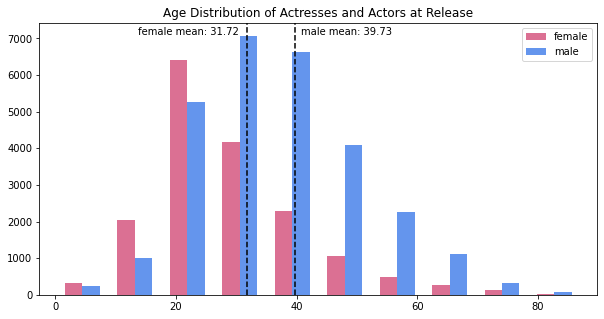

In [172]:
# age gap between actresses and actors
female_chara = age[age['actor_gender']=='F'].dropna()
male_chara = age[age['actor_gender']=='M'].dropna()
np.random.seed(0)
fig, ax = plt.subplots(figsize=(10, 5))
a_heights, a_bins = np.histogram(female_chara['actor_age_at_release'])
b_heights, b_bins = np.histogram(male_chara['actor_age_at_release'], bins=a_bins)
width = (a_bins[1] - a_bins[0])/3
ax.bar(a_bins[:-1], a_heights, width=width, facecolor='palevioletred',label='female')
ax.axvline(female_chara['actor_age_at_release'].mean(), color='k', linestyle='dashed', linewidth=1.5)
ax.text(female_chara['actor_age_at_release'].mean()-18,7100,'female mean: {:.2f}'.format(female_chara['actor_age_at_release'].mean()))

ax.bar(b_bins[:-1]+width, b_heights, width=width, facecolor='cornflowerblue',label='male')
ax.axvline(male_chara['actor_age_at_release'].mean(), color='k', linestyle='dashed', linewidth=1.5)
ax.text(male_chara['actor_age_at_release'].mean()+1,7100,'male mean: {:.2f}'.format(male_chara['actor_age_at_release'].mean()))
ax.legend()
ax.set_title('Age Distribution of Actresses and Actors at Release')

#### From the age distribution plot, we can see that the averge age of actors is around 40 years old, which is 8 years elder than actresses( a huge gap! ) . Also, age distribution of actors is closer to normal distribution, while actresses declines dramatically once they are no longer at their 'best age'. Women tend to have shorter career in acting. It's also noteworthy that for actors at the same age, men are dominant after 30 years old. It implies that good looks may be more valued for actresses than actors in movie industry.

#### 2.2.2 Director and writer

In [ ]:
# TODO

###  2.3 Gender difference in different domains
#### 2.3.1 Genre

In [181]:
movie_genres = movies.copy()
movie_genres['genres'] = movie_genres['genres'].apply(lambda x: list(eval(x).values()))
movie_genres = movie_genres.explode('genres', ignore_index = True)
movie_genres = movie_genres.drop(columns=['freebase_movie_id', 'movie_name','release_date','box_office_revenue',
              'movie_runtime', 'languages','countries'])
genres_ct = movie_genres['genres'].value_counts()
top30_genres = movie_genres['genres'].value_counts()[:30].index.tolist()

In [182]:
# consider a genre is general when at least 100 movies in it
general_genres = genres_ct[genres_ct > 100]
general_genres = general_genres.index.tolist()

In [183]:
character_genres = pd.merge(left = characters, right = movie_genres, left_on = 'wiki_movie_id', right_on = 'wiki_movie_id', how = 'inner')

In [184]:
female_genres = character_genres[character_genres.genres.isin(general_genres)][['actor_gender', 'genres']].groupby('genres').agg('sum')
female_genres['female_ratio'] = female_genres['actor_gender'].apply(lambda x: get_female_ratio(x))
female_genres = female_genres.drop(columns=['actor_gender'])
female_genres = female_genres.sort_values(by='female_ratio', ascending=False).iloc[:30]

[Text(0.5, 1.0, 'Top 30 Female Genres')]

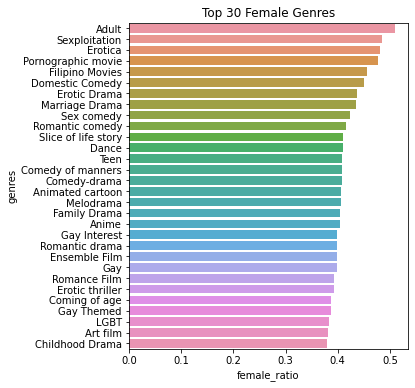

In [185]:
female_genres['genres'] = female_genres.index
f, ax = plt.subplots(figsize=(5, 6))
sns.barplot(data=female_genres, x="female_ratio", y="genres").set(title='Top 30 Female Genres')

In [186]:
genre_gender = character_genres[character_genres.genres.isin(top30_genres)][['actor_gender', 'genres']].groupby('genres').agg('sum')
genre_gender['female_ratio'] = genre_gender['actor_gender'].apply(lambda x: get_female_ratio(x))
genre_gender = genre_gender.drop(columns=['actor_gender'])
genre_gender = genre_gender.sort_values(by='female_ratio', ascending=False)

[Text(0.5, 1.0, 'Female cast ratio in top 30 genres')]

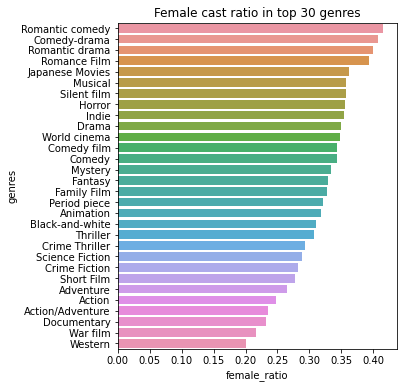

In [187]:
genre_gender['genres'] = genre_gender.index
f, ax = plt.subplots(figsize=(5, 6))
sns.barplot(data=genre_gender, x="female_ratio", y="genres").set(title='Female cast ratio in top 30 genres')

#### 2.3.1 Language

In [188]:
# TODO plot

## Task 3 Extract verbs and adjectives of the plot's summaries

In [ ]:
# Load spacy pipeline
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("merge_entities") # Merge entities like ['David' 'Bowie'] to ['David Bowie']

In [ ]:
def tag_adj(text):
    """
    Find all noon/adjective pair in the given text
    :param text: Text composed of one or multiple sentences
    :return: list of noon/adjective pair
    """
    doc = nlp(text)
    noun_adj_pairs = []
    for token in doc:
        ## Is the word a proper noun / noun / pronoun
        if token.pos_ in ('PROPN', 'NOUN', 'PRON'):
            for child in token.children:
                ## Is the child an adjectival modifier
                if child.dep_ == 'amod':
                    noun_adj_pairs.append((token.lemma_, child.lemma_))
    return noun_adj_pairs

In [ ]:
## Example
print(tag_adj("There is a red card in the blue envelope and a beautiful girl."))
print(tag_adj("She is beautiful."))

In [ ]:
def tag_verb(text):
    """
    Find all noon/verb pair in the given text
    :param text: Text composed of one or multiple sentences
    :return: list of noon/verb pair
    """
    doc = nlp(text)
    verbs = []
    for possible_verb in doc:
        if possible_verb.pos_ == 'VERB':
            for possible_subject in possible_verb.children:
                if possible_subject.dep_ == 'nsubj':
                    verbs.append((possible_subject.lemma_, possible_verb.lemma_))
                    break
    return verbs

We extract the adjectives and verbs of each plot

In [ ]:
plots['verb'] = plots['plot'].apply(tag_verb) # long computation

In [ ]:
plots['adj'] = plots['plot'].apply(tag_adj) # long computation

In [ ]:
# Save intermediate result since computation is quite long
plots[['wiki_movie_id', 'verb', 'adj']].to_pickle('data/plots.pickle')

In [ ]:
# Dict that match all characters to their gender
matcher = pd.Series(characters.actor_gender.values, index=characters.character_name).to_dict()
matcher.update({'he' : 'M', 'she' : 'F'})

In [ ]:
plots[['wiki_movie_id', 'verb', 'adj']] = pd.read_pickle('data/plots.pickle')

In [ ]:
# We build a dataframe that groups the subject and the verb of every plot
gender_verb = pd.DataFrame(plots.verb.explode().to_list(), columns=['noon', 'verb'])
gender_verb.head()

In [ ]:
# We create a new column that assignee to subject to male or female based on the matcher
gender_verb['gender'] = gender_verb.noon.apply(matcher.get)
gender_verb.dropna(inplace=True)
gender_verb.head()

In [ ]:
# We do the same for adjectives
gender_adj = pd.DataFrame(plots.adj.explode().to_list(), columns=['noon', 'adj'])
gender_adj['gender'] = gender_adj.noon.apply(matcher.get) ## TODO is this matcher adequate ???
gender_adj.dropna(inplace=True)
gender_adj.head()

Now we can study the occurrence of each word per gender in the plots (needs some filtering)

In [ ]:
gender_verb.loc[gender_verb.gender == 'F'].verb.value_counts().head(10)

In [ ]:
gender_verb.loc[gender_verb.gender == 'M'].verb.value_counts().head(10)

In [ ]:
gender_adj.loc[gender_adj.gender == 'F'].adj.value_counts().head(10)

In [ ]:
gender_adj.loc[gender_adj.gender == 'M'].adj.value_counts().head(10)

## Task 4 Sentiment Analysis